# Prophet extension

In [24]:
from ipynb.fs.defs.prophet import generateDistribution, Finv
import pandas as pd
import numpy as np
from tqdm import tqdm # for the progress bar
from statistics import mean
import matplotlib.pyplot as plt
import dataframe_image as dfi

In [25]:
def FairGeneralProphetExtended(q, V, distribution_type, epsilon):
    s = 0.0
    n = len(V)
    for i in range(0,n): #value < 1 reaches a drop!
        p = (1- (q[i]/2)/(epsilon-(s/2)))
        if V[i] >= Finv(distribution_type, p):
            return i
        s += q[i]

def FairIIDProphetExtended(V, distribution_type, epsilon):
    n = len(V)
    for i in range(0, n):
        p = 1 - (2/(3*n)) / (epsilon - 2*(i-1)/(3*n))
        if V[i] >= Finv(distribution_type, p):
                 return i
        
def runExperimentExtended(algorithm, N_experimentReps, distribution_type, n_candidates, epsilon):
    arrivalPositionsChosen, chosenValues, chosenValuesExcludeNone = [0]*n_candidates, [], []
    nones = 0
    for _ in tqdm(range(0, N_experimentReps)):
        q, Values = generateDistribution(distribution_type, n_candidates)
        
        if algorithm == "FairGeneralProphet":
                result = FairGeneralProphetExtended(q, Values, distribution_type, epsilon)
        elif algorithm == "FairIIDProphet":
                result = FairIIDProphetExtended(Values, distribution_type, epsilon)
        if result != None:
            arrivalPositionsChosen[result] += 1
            chosenValues.append(Values[result])
            chosenValuesExcludeNone.append(Values[result])
            
        if result == None: 
            chosenValues.append(0)
            nones += 1     
        
    noneRate = nones/N_experimentReps
        
    return noneRate, mean(chosenValues), mean(chosenValuesExcludeNone), arrivalPositionsChosen

100%|██████████| 50000/50000 [00:04<00:00, 10780.42it/s]


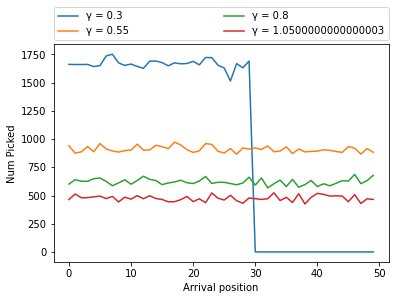

In [28]:
#Fair general prophet Uniform distribution
df = pd.DataFrame(columns=['epsilon', 'None rate', "Mean value (None=0)", "Mean value (excluding None)"])
for param in np.arange(0.3, 1.2, .25):
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairGeneralProphet", 
                                                                                 N_experimentReps=50000,
                                                                                 distribution_type="uniform", 
                                                                                 n_candidates=50, 
                                                                                 epsilon=param
                                                                                )
    
    a_series = pd.Series([param,nonerate,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)

    plt.plot(range(0,50), chosen_positions, label= str("γ = " + str(param)))
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.savefig("images/extensionFairPA_uniform.png")
dfi.export(df, 'images/extenstionFairPA_table_uniform.png')

In [ ]:
#Fair general prophet Binomial distribution
df = pd.DataFrame(columns=['epsilon', 'None rate', "Mean value (None=0)", "Mean value (excluding None)"])
for param in np.arange(0.3, 1.2, .25):
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairGeneralProphet", 
                                                                                 N_experimentReps=5000,
                                                                                 distribution_type="binomial", 
                                                                                 n_candidates=500, 
                                                                                 epsilon=param
                                                                                )
    
    a_series = pd.Series([param,nonerate,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)

    plt.plot(range(0,100), chosen_positions, label= str("γ = " + str(param)))
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
# plt.savefig("images/extensionFairPA_binomial.png")
# dfi.export(df, 'images/extenstionFairPA_table_binomial.png')

100%|██████████| 50000/50000 [00:05<00:00, 9323.53it/s] 


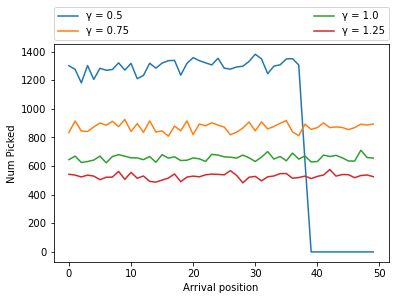

In [31]:
#Fair IID prophet Uniform distribution
df = pd.DataFrame(columns=['epsilon', 'None rate', "Mean value (None=0)", "Mean value (excluding None)"])
for param in np.arange(0.5, 1.5, .25):
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairIIDProphet", 
                                                                                 N_experimentReps=50000,
                                                                                 distribution_type="uniform", 
                                                                                 n_candidates=50, 
                                                                                 epsilon=param
                                                                                )
    
    a_series = pd.Series([param,nonerate,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)
    plt.plot(range(0,50), chosen_positions, label= str("γ = " + str(param)))
    
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.savefig("images/extensionFairIID_table_uniform.png")
dfi.export(df, "images/extenstionFairIID_table_uniform.png")

In [ ]:
#Fair IID prophet Binomial distribution
df = pd.DataFrame(columns=['epsilon', 'None rate', "Mean value (None=0)", "Mean value (excluding None)"])
for param in np.arange(0.5, 1.5, .25):
    nonerate, avg_include, avg_exclude, chosen_positions = runExperimentExtended(algorithm="FairIIDProphet", 
                                                                                 N_experimentReps=5000,
                                                                                 distribution_type="binomial", 
                                                                                 n_candidates=500, 
                                                                                 epsilon=param
                                                                                )
    
    a_series = pd.Series([param,nonerate,avg_include,avg_exclude], index = df.columns)
    df = df.append(a_series, ignore_index=True)
    plt.plot(range(0,100), chosen_positions, label= str("γ = " + str(param)))
    
plt.xlabel("Arrival position")
plt.ylabel("Num Picked")
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
# plt.savefig("images/extensionFairIID_table_binomial.png")
# dfi.export(df, "images/extenstionFairIID_table_binomial.png")

 24%|██▎       | 1184/5000 [00:43<02:34, 24.74it/s]